# Flight efficiency map

Load packages, load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from cmcrameri import cm as scm
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec

In [2]:
flights = pd.read_csv("../data/by_route_airline.csv")
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,rpk,average_load,co2,gco2_pax_km
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,2.515524e+09,0.814869,191365.676340,76.073891
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,2.480272e+09,0.814869,195266.817616,78.727996
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,8.936213e+08,0.839453,100145.929946,112.067534
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,8.619707e+08,0.839453,96146.969851,111.543198
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,1.678008e+09,0.700556,161111.234068,96.013360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,OSL,BOO,14.365300,67.269203,11.100400,60.193901,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,2.278307e+04,0.646481,3.184374,139.769276
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,2.302834e+04,0.785064,3.052329,132.546626
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,2.302834e+04,0.785064,3.052329,132.546626
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,1.910700e+04,0.703706,2.493229,130.487717


In [3]:
flights['RPK'] = flights['passengers'] / flights['flights'] * flights['flown_distance']
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,rpk,average_load,co2,gco2_pax_km,RPK
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,2.515524e+09,0.814869,191365.676340,76.073891,2.515524e+09
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,2.480272e+09,0.814869,195266.817616,78.727996,2.480272e+09
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,8.936213e+08,0.839453,100145.929946,112.067534,8.936213e+08
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,8.619707e+08,0.839453,96146.969851,111.543198,8.619707e+08
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,1.678008e+09,0.700556,161111.234068,96.013360,1.678008e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,OSL,BOO,14.365300,67.269203,11.100400,60.193901,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,2.278307e+04,0.646481,3.184374,139.769276,2.278307e+04
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,2.302834e+04,0.785064,3.052329,132.546626,2.302834e+04
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,2.302834e+04,0.785064,3.052329,132.546626,2.302834e+04
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,1.910700e+04,0.703706,2.493229,130.487717,1.910700e+04


List of unique airports

In [4]:
# list of unique airports
airports_departure = set(flights["departure"].values)
airports_arrival = set(flights["arrival"].values)
airports = np.array(list(airports_departure | airports_arrival))
airports

array(['BCM', 'OSR', 'CAN', ..., 'PVG', 'BWX', 'DMU'],
      shape=(3218,), dtype='<U3')

Sum of CO2 per airport (1/2 arrival, 1/2 departure)

In [5]:
departure = np.array(flights['departure'])
arrival = np.array(flights['arrival'])

co2 = np.array([sum(flights[departure == airport]['co2'])/2 +
          sum(flights[arrival == airport]['co2'])/2 for airport in airports])

RPK = np.array([sum(flights[departure == airport]['RPK'])/2 +
          sum(flights[arrival == airport]['RPK'])/2 for airport in airports])

Coordinates of each airport

In [6]:
longitude_airport = np.zeros(len(airports))
latitude_airport = np.zeros(len(airports))

for i, airport in enumerate(airports):
    if airport in arrival:      # not all airports are in arrival
        row = flights[arrival == airport]
    else:
        row = flights[departure == airport]    
    
    longitude_airport[i] = row['arrival_longitude'].iloc[0]
    latitude_airport[i] = row['arrival_latitude'].iloc[0]


RPK-averaged CO2 intensity 

In [7]:
# from tCO2 to gCO2
mean_intensity = 1000**2*co2/RPK

Flight paths via great circle distance between departure and arrival airport

In [8]:
sample = range(len(flights))                            # all flights or subsample to test?
sample_random = np.random.shuffle(np.copy(sample))      # randomize 

latitude_departure = np.array(flights["departure_latitude"])[sample_random]
longitude_departure = np.array(flights["departure_longitude"])[sample_random]

latitude_arrival = np.array(flights["arrival_latitude"])[sample_random]
longitude_arrival = np.array(flights["arrival_longitude"])[sample_random]

Flight CO2 intensity in gCO2/pax/km, use flown distance, not great circle distance

In [9]:
p5, p50, p95 = np.percentile(co2, 4.947), np.percentile(co2, 50.296), np.percentile(co2, 95.492)
p5, p50, p95

(np.float64(100.04374705847029),
 np.float64(8000.173642628229),
 np.float64(800022.4217176142))

In [10]:
# rounded
p5, p50, p95 = 100, 8_000, 800_000

# Plot the map

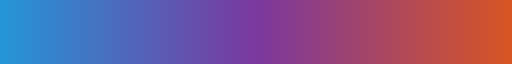

In [11]:
c1 = np.array([0.147, 0.586, 0.845, 1.0])
c2 = np.array([0.484, 0.222, 0.624, 1.0])
c3 = np.array([0.845, 0.335, 0.147, 1.0])
new_cmap = LinearSegmentedColormap.from_list('two_colors', (c1, c2, c3), N=64)
new_cmap

/var/folders/p7/_wtvftrs34b18wzt6626m78w0000gp/T/ipykernel_9404/2013844786.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=0)


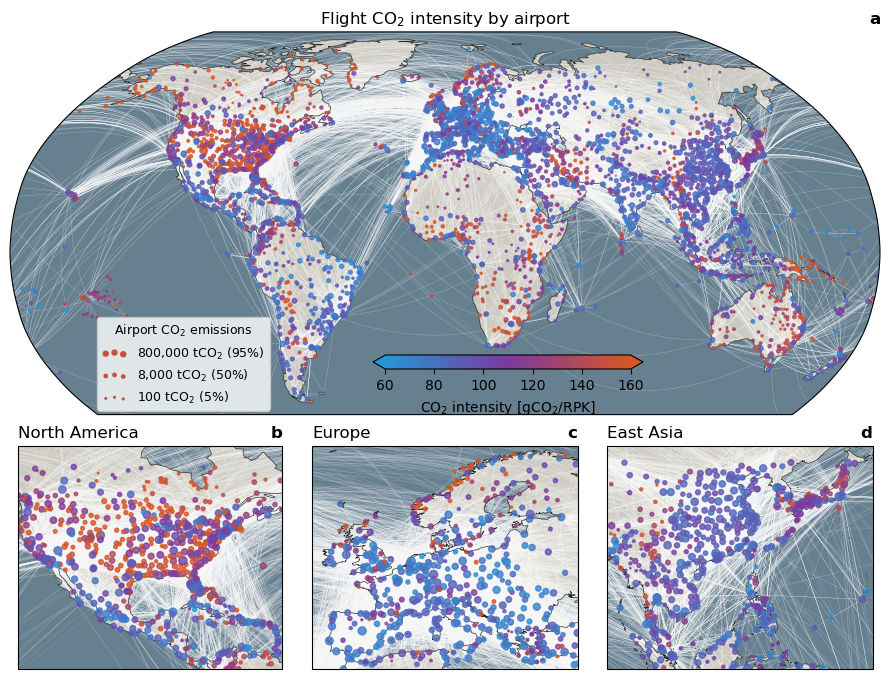

In [12]:
fig = plt.figure(figsize=(9, 7))

gs = GridSpec(3, 3, figure=fig)
ax  = fig.add_subplot(gs[:2, :], projection=ccrs.Robinson())
ax1 = fig.add_subplot(gs[2,  0], projection=ccrs.PlateCarree(central_longitude=-100))
ax2 = fig.add_subplot(gs[2,  1], projection=ccrs.PlateCarree(central_longitude=10))
ax3 = fig.add_subplot(gs[2,  2], projection=ccrs.PlateCarree(central_longitude=120))
cax = fig.add_axes([0.42, 0.45, 0.3, 0.02])

ax.set_extent([-180, 180, -60, 90])
ax.add_feature(cfeature.OCEAN, facecolor="#668090",zorder=-3, rasterized=True)
ax.add_feature(cfeature.LAND, facecolor="#cccac0", zorder=-2, rasterized=True)
ax.coastlines(color="k", alpha=0.8, lw=0.5, zorder=0.2)

ax.plot(np.vstack((longitude_departure, longitude_arrival)),
        np.vstack((latitude_departure, latitude_arrival)), color="w", lw=.2, alpha=0.3, transform=ccrs.Geodetic(), zorder=.1, rasterized=True)

vmin, vmax = 60, 160
h = ax.scatter(0, 0, 0, 0, vmin=vmin, vmax=vmax, alpha=1, cmap=new_cmap, visible=False)

f = lambda x: 7e-2*np.log(x)**2
ax.scatter(0, -100, f(p95), 150, vmin=vmin, vmax=vmax,
           alpha=1, cmap=new_cmap, transform=ccrs.PlateCarree(), zorder=1, label="{:,.0f} tCO$_2$ (95%)".format(p95))
ax.scatter(0, -100, f(p50), 150, vmin=vmin, vmax=vmax,
           alpha=1, cmap=new_cmap, transform=ccrs.PlateCarree(), zorder=1, label="{:,.0f} tCO$_2$ (50%)".format(p50))
ax.scatter(0, -100, f(p5), 150, vmin=vmin, vmax=vmax,
           alpha=1, cmap=new_cmap, transform=ccrs.PlateCarree(), zorder=1, label="{:,.0f} tCO$_2$ (5%)".format(p5))

ax.legend(loc=(0.1, 0.01), scatterpoints=3, fontsize=9, title="Airport CO$_2$ emissions", title_fontsize=9)

ax.scatter(longitude_airport, latitude_airport, f(co2), mean_intensity,
               vmin=vmin, vmax=vmax, alpha=0.8, cmap=new_cmap, transform=ccrs.PlateCarree())

fig.colorbar(h, cax=cax, orientation='horizontal', label="CO$_2$ intensity [gCO$_2$/RPK]", extend="both")

ax.set_title("Flight CO$_2$ intensity by airport")
ax.set_title("a", loc="right", fontweight="bold")

## THE OTHER THREE SUBPLOTS
ax1_extent = [-125, -60, 7, 58]
ax2_extent = [-12, 33, 34, 70.5]
ax3_extent = [90, 147, -1.5, 43]

ax1.set_extent(ax1_extent, crs=ccrs.Geodetic())
ax2.set_extent(ax2_extent, crs=ccrs.Geodetic())
ax3.set_extent(ax3_extent, crs=ccrs.Geodetic())

for ax in (ax1, ax2, ax3):
    ax.add_feature(cfeature.OCEAN, facecolor="#668090",zorder=-3, rasterized=True)
    ax.add_feature(cfeature.LAND, facecolor="#cccac0", zorder=-2, rasterized=True)
    ax.coastlines(color="k", alpha=0.8, lw=0.5, zorder=0.2)

vmin, vmax = 60, 160
h = ax1.scatter(0, 0, 0, 0, vmin=vmin, vmax=vmax, alpha=1, cmap="viridis_r", visible=False)

for (ax, ext) in zip((ax1, ax2, ax3), (ax1_extent, ax2_extent, ax3_extent)):

    # subset scatter points as vector graphic save to pdf would store
    # the ones outside the axis extent
    west = longitude_airport > ext[0]
    east = longitude_airport < ext[1]
    south = latitude_airport > ext[2]
    north = latitude_airport < ext[3]
    subset = east & west & south & north
    
    lon_subset = longitude_airport[subset]
    lat_subset = latitude_airport[subset]
    
    ax.plot(np.vstack((longitude_departure, longitude_arrival)),
            np.vstack((latitude_departure, latitude_arrival)), color="w", lw=.2, alpha=0.3, transform=ccrs.Geodetic(), zorder=.1, rasterized=True)
    ax.scatter(lon_subset, lat_subset, 2*f(co2[subset]), mean_intensity[subset],
               vmin=vmin, vmax=vmax, alpha=0.8, cmap=new_cmap, transform=ccrs.PlateCarree())

ax1.set_title("North America", loc="left")
ax2.set_title("Europe", loc="left")
ax3.set_title("East Asia", loc="left")

ax1.set_title("b", loc="right", fontweight="bold")
ax2.set_title("c", loc="right", fontweight="bold")
ax3.set_title("d", loc="right", fontweight="bold")

plt.tight_layout(h_pad=0)
plt.savefig("map.pdf", dpi=150)
plt.show()

Fig. ?: CO2 intensity per flight connection. Thin black lines denote the flight path between two airports along the respective great circle (actual paths include detours, holding, etc.). Departure airports are marked by location and colour-coded to show the carbon intensity, in carbon emissions (gCO2) through fuel burn by aircraft type, per passenger (average load factor for that flight connection), per flown kilometre (accounting for detours or holding). (b-d) Zooming into (b) North America, (c) Europe, (d) East Asia.